Data splits shapes:
  X_train: (31428, 5000), X_val: (6735, 5000), X_test: (6735, 5000)
---- Test provided examples ----
📰 Breaking news: Scientists discover a new species in the Amazon rainforest.
    → Predicted: fake (p_real=0.00, p_fake=1.00)

📰 Local health officials report that vaccination rates have reached a record high this quarter.
    → Predicted: fake (p_real=0.00, p_fake=1.00)

📰 In an exclusive interview, the celebrity reveals her secret to eternal youth.
    → Predicted: fake (p_real=0.00, p_fake=1.00)

---- Sample from True.csv ----
📰 PARIS (Reuters) - French President Francois Hollande and U.S President-elect Donald Trump had a phone conversation on Friday in which they agreed to clarify positions on key issues such as the Middle East and Ukraine, said a source in Hollande’s camp. The source told Reuters that the phone conversation lasted between seven and eight minutes and took place in “good conditions”. “They agreed to work together on a number of key issues in orde

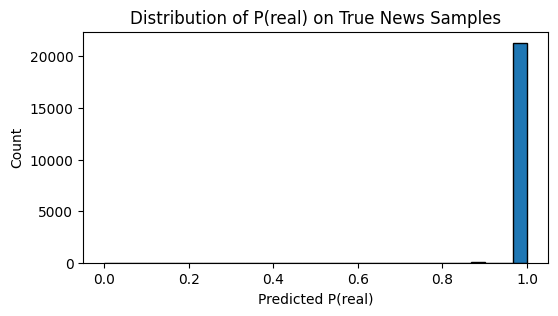

Using threshold = 0.998
---- Synthetic headlines ----
📰 Scientists announce discovery of perpetual motion machine.
    → fake (p_real=0.000)

📰 Government declares pizza the official state vegetable.
    → fake (p_real=0.010)

📰 Alien spacecraft lands in Central Park to negotiate peace.
    → fake (p_real=0.010)

📰 Study finds that chocolate cures all diseases overnight.
    → fake (p_real=0.000)

Using threshold = 0.970
Classification Report on TEST set:
              precision    recall  f1-score   support

        fake       0.99      1.00      0.99      3523
        real       1.00      0.99      0.99      3212

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



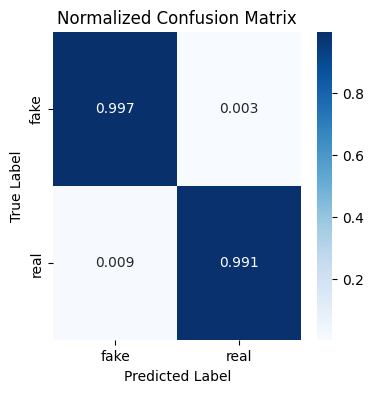

In [1]:
# 1) Imports
import re
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 2) Load artifacts from ../models/
tfidf = joblib.load('../models/tfidf_vectorizer.joblib')
model = joblib.load('../models/final_fake_news_model.joblib')

# 3) Recreate train/validation/test split (70/15/15) using the same TF-IDF
#    so that X_test and y_test become available in this notebook.
fake_df = pd.read_csv('../data/raw/Fake.csv')
real_df = pd.read_csv('../data/raw/True.csv')
fake_df['label'] = 0
real_df['label'] = 1

# a) Combine and simple clean (lowercase and remove non-letters)
df = pd.concat([fake_df, real_df], ignore_index=True)
df['clean_text'] = df['text'].astype(str).apply(lambda t: re.sub(r'[^a-z\s]', ' ', t.lower()))

# b) Vectorize with the loaded TF-IDF
X_all = tfidf.transform(df['clean_text'])
y_all = df['label'].values

# c) Split into train, validation, test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.30, random_state=42, stratify=y_all
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Data splits shapes:")
print(f"  X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

# 4) Define a helper to classify arbitrary texts
def classify_texts(texts, threshold=0.7):
    """
    texts: list of strings
    threshold: cutoff on P(real) above which label is 'real'
    """
    X_new  = tfidf.transform(texts)
    probs  = model.predict_proba(X_new)[:,1]  # P(real)
    preds  = (probs >= threshold).astype(int)
    for txt, p, pr in zip(texts, probs, preds):
        label = 'real' if pr==1 else 'fake'
        print(f"📰 {txt}\n    → Predicted: {label} "
              f"(p_real={p:.2f}, p_fake={(1-p):.2f})\n")

# 5) Test provided examples
test_headlines = [
    "Breaking news: Scientists discover a new species in the Amazon rainforest.",
    "Local health officials report that vaccination rates have reached a record high this quarter.",
    "In an exclusive interview, the celebrity reveals her secret to eternal youth."
]
print("---- Test provided examples ----")
classify_texts(test_headlines, threshold=0.7)

# 6) Verify with one random real‐news article
example_real = real_df['text'].sample(1).tolist()
print("---- Sample from True.csv ----")
classify_texts(example_real, threshold=0.7)

# 7) Verify with one random fake‐news article
example_fake = fake_df['text'].sample(1).tolist()
print("---- Sample from Fake.csv ----")
classify_texts(example_fake, threshold=0.7)

# 8) Analyze P(real) distribution on all true‐news articles
probs_real = model.predict_proba(tfidf.transform(real_df['text']))[:,1]
print("Min P(real):", np.min(probs_real))
print("1st percentile:", np.percentile(probs_real, 1))
print("5th percentile:", np.percentile(probs_real, 5))
print("10th percentile:", np.percentile(probs_real, 10))
print("Median:", np.median(probs_real))
print("Mean:", np.mean(probs_real))
plt.figure(figsize=(6,3))
plt.hist(probs_real, bins=30, edgecolor='k')
plt.title("Distribution of P(real) on True News Samples")
plt.xlabel("Predicted P(real)")
plt.ylabel("Count")
plt.show()

# 9) Evaluate on synthetic “invented” headlines
invented = [
    "Scientists announce discovery of perpetual motion machine.",
    "Government declares pizza the official state vegetable.",
    "Alien spacecraft lands in Central Park to negotiate peace.",
    "Study finds that chocolate cures all diseases overnight."
]
threshold = np.percentile(probs_real, 5)  # e.g. 5th percentile cutoff
print(f"Using threshold = {threshold:.3f}\n---- Synthetic headlines ----")
for txt in invented:
    p = model.predict_proba(tfidf.transform([txt]))[0,1]
    label = 'real' if p >= threshold else 'fake'
    print(f"📰 {txt}\n    → {label} (p_real={p:.3f})\n")

# 10) Evaluate on the full test set with a high threshold
threshold = np.percentile(probs_real, 1)  # e.g. 1st percentile for 99% recall
y_test_prob = model.predict_proba(X_test)[:,1]
y_test_pred = (y_test_prob >= threshold).astype(int)

print(f"Using threshold = {threshold:.3f}\nClassification Report on TEST set:")
print(classification_report(y_test, y_test_pred, target_names=['fake','real']))

cm = confusion_matrix(y_test, y_test_pred, normalize='true')
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".3f", cmap="Blues",
            xticklabels=['fake','real'], yticklabels=['fake','real'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()
